Create plot for full ensemble of SLR projections for 3 SSPs and 2 basal melt parameterisations

Ensemble contains a range of 14 ESMs and 8 ISMs

Computation is done with and without feedback

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import utils as ut

In [2]:
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .15
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,5)

bmps_long = ['linear basal melt','quadratic basal melt']

In [9]:
#year0,year1 = 1851,2000
year0,year1 = 1951,2100

#option = ''
option = '_fit'

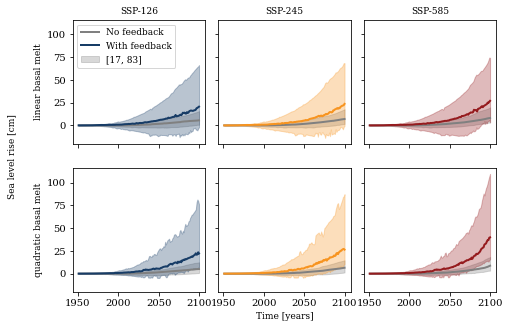

In [11]:
alpha = .3
perc = [17,83]

fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
for b,bmp in enumerate(ut.bmps):
    ds = xr.open_dataset(f'../data/ensemble{option}_{bmp}_{year0}_{year1}.nc')
    try:
        ds = ds.drop_sel(ism='PISM_DMI')
    except:
        pass
    for s,ss in enumerate(ds.ssp.values):
        dax = ax[b,s]
        dax.plot(ds.time,100*np.median(ds.slr_nf[s,:,:,:],axis=(0,1)),c='.5',lw=2,label='No feedback')
        dax.fill_between(ds.time,100*np.percentile(ds.slr_nf[s,:,:,:],perc[0],axis=(0,1)),100*np.percentile(ds.slr_nf[s,:,:,:],perc[1],axis=(0,1)),color='.5',alpha=alpha,label=perc)

        dax.plot(ds.time,100*np.median(ds.slr_wf[s,:,:,:],axis=(0,1)),c=ut.scol[ss],lw=2,label='With feedback')
        dax.fill_between(ds.time,100*np.percentile(ds.slr_wf[s,:,:,:],perc[0],axis=(0,1)),100*np.percentile(ds.slr_wf[s,:,:,:],perc[1],axis=(0,1)),color=ut.scol[ss],alpha=alpha)
        if b==0:
            dax.set_title(f'SSP-{ss}')
    ds.close()
    ax[b,0].set_ylabel(bmps_long[b])
            
ax[0,0].legend(loc='upper left')
fig.supylabel('Sea level rise [cm]',fontsize=9)
ax[1,1].set_xlabel('Time [years]')

plt.savefig(f'../draftfigs/full_ensemble{option}_{year0}_{year1}.png',dpi=450,facecolor='w',transparent=False)
plt.show()